In [5]:
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

users_df = pd.read_csv("C:/Users/madhu/Downloads/Relax_Challenge/takehome_users.csv", encoding='ISO-8859-1')
engagement_df = pd.read_csv("C:/Users/madhu/Downloads/Relax_Challenge/takehome_user_engagement.csv", encoding='ISO-8859-1')

In [7]:
users_df['creation_time'] = pd.to_datetime(users_df['creation_time'])
users_df['last_session_creation_time'] = pd.to_datetime(users_df['last_session_creation_time'], unit='s')

# Convert 'time_stamp' in engagement data to datetime
engagement_df['time_stamp'] = pd.to_datetime(engagement_df['time_stamp'])

# Display the updated data types
print(users_df.dtypes)
print(engagement_df.dtypes)

object_id                              int64
creation_time                 datetime64[ns]
name                                  object
email                                 object
creation_source                       object
last_session_creation_time    datetime64[ns]
opted_in_to_mailing_list               int64
enabled_for_marketing_drip             int64
org_id                                 int64
invited_by_user_id                   float64
dtype: object
time_stamp    datetime64[ns]
user_id                int64
visited                int64
dtype: object


In [9]:
# Handling missing values in 'last_session_creation_time' by filling with the 'creation_time'
users_df['last_session_creation_time'].fillna(users_df['creation_time'], inplace=True)

# Handling missing values in 'invited_by_user_id' by filling with 0 (indicating not invited)
users_df['invited_by_user_id'].fillna(0, inplace=True)

# Verify missing values have been handled
print(users_df.isnull().sum())


object_id                     0
creation_time                 0
name                          0
email                         0
creation_source               0
last_session_creation_time    0
opted_in_to_mailing_list      0
enabled_for_marketing_drip    0
org_id                        0
invited_by_user_id            0
dtype: int64


C:\Users\madhu\AppData\Local\Temp\ipykernel_33344\1790357706.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  users_df['last_session_creation_time'].fillna(users_df['creation_time'], inplace=True)
C:\Users\madhu\AppData\Local\Temp\ipykernel_33344\1790357706.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting val

In [11]:
# Calculate the number of days since account creation until the last session
users_df['days_since_creation'] = (users_df['last_session_creation_time'] - users_df['creation_time']).dt.days

# Display the first few rows to verify
print(users_df[['creation_time', 'last_session_creation_time', 'days_since_creation']].head())


        creation_time last_session_creation_time  days_since_creation
0 2014-04-22 03:53:30        2014-04-22 03:53:30                    0
1 2013-11-15 03:45:04        2014-03-31 03:45:04                  136
2 2013-03-19 23:14:52        2013-03-19 23:14:52                    0
3 2013-05-21 08:09:28        2013-05-22 08:09:28                    1
4 2013-01-17 10:14:20        2013-01-22 10:14:20                    5


In [13]:
# Merge users with engagement data on user_id
merged_df = pd.merge(users_df, engagement_df, left_on='object_id', right_on='user_id')

# Calculate the difference between the login timestamp and the account creation time
merged_df['days_after_creation'] = (merged_df['time_stamp'] - merged_df['creation_time']).dt.days

# Filter logins that occurred within the first 7 days
first_week_logins = merged_df[merged_df['days_after_creation'] <= 7]

# Count logins in the first week
login_counts_first_week = first_week_logins.groupby('user_id').size()

# Add this count to the users_df
users_df['logins_first_week'] = users_df['object_id'].map(login_counts_first_week).fillna(0)

# Display the first few rows to verify
print(users_df[['object_id', 'logins_first_week']].head())


   object_id  logins_first_week
0          1                1.0
1          2                1.0
2          3                1.0
3          4                1.0
4          5                1.0


In [15]:
# Display first few rows to check invited_by_user_id
print(users_df[['object_id', 'invited_by_user_id']].head())


   object_id  invited_by_user_id
0          1             10803.0
1          2               316.0
2          3              1525.0
3          4              5151.0
4          5              5240.0


In [17]:
# Count the number of unique days each user logged in
user_login_days = engagement_df.groupby('user_id')['time_stamp'].nunique()

# Flag users as adopted if they have logged in on three separate days within a seven-day period
adopted_users = user_login_days[user_login_days >= 3].index

# Add the adopted user flag to the users_df
users_df['adopted_user'] = users_df['object_id'].isin(adopted_users).astype(int)

# Display the first few rows to verify
print(users_df[['object_id', 'adopted_user']].head())


   object_id  adopted_user
0          1             0
1          2             1
2          3             0
3          4             0
4          5             0


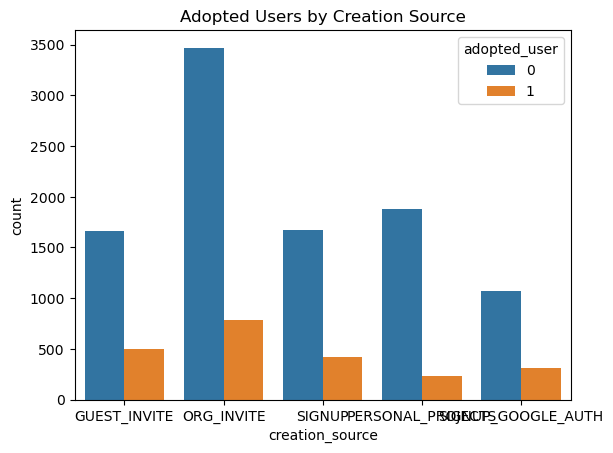

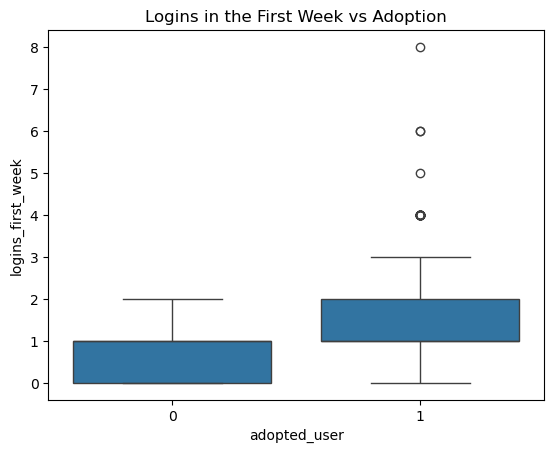

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the distribution of 'adopted_user' across different 'creation_source'
sns.countplot(data=users_df, x='creation_source', hue='adopted_user')
plt.title('Adopted Users by Creation Source')
plt.show()

# Plot the distribution of 'adopted_user' by the number of logins in the first week
sns.boxplot(data=users_df, x='adopted_user', y='logins_first_week')
plt.title('Logins in the First Week vs Adoption')
plt.show()


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Select features and target variable
features = users_df[['days_since_creation', 'logins_first_week', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip']]
target = users_df['adopted_user']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# Build a RandomForest Classifier model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.9866666666666667
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2939
           1       0.96      0.96      0.96       661

    accuracy                           0.99      3600
   macro avg       0.98      0.98      0.98      3600
weighted avg       0.99      0.99      0.99      3600



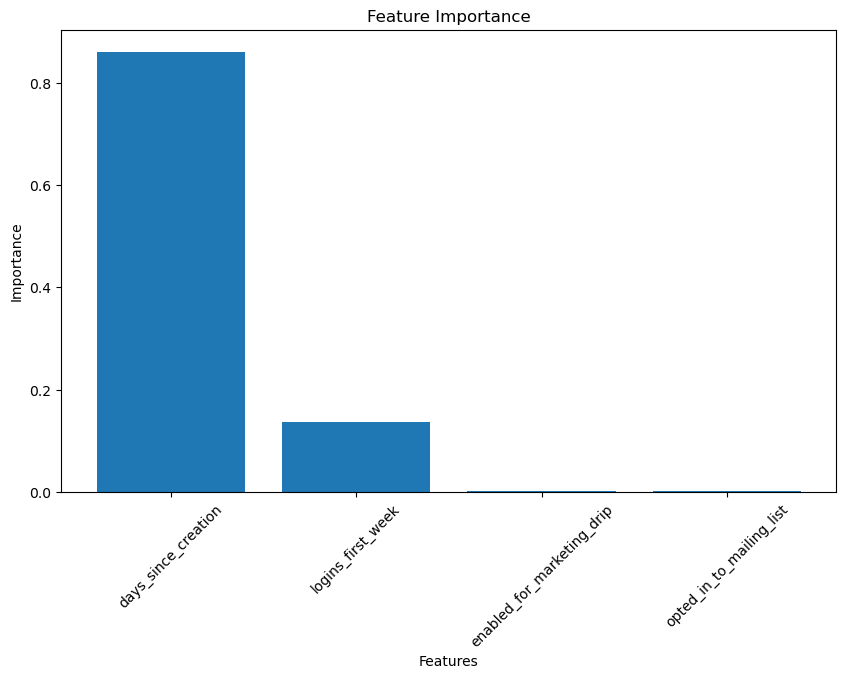

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Extract feature importances from the model
importances = model.feature_importances_
feature_names = features.columns

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Arrange the feature names according to their importance
sorted_feature_names = [feature_names[i] for i in indices]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), sorted_feature_names, rotation=45)
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()
